# ECG anormaly detection using LSTM-AE network.
Last update: March 9, 2023\
Author: Chang-Gil, Jeong

Preprocessing from original database.\
filtering, segmentation

In [1]:
import Preprocessing

fs = 360
fsTarget = 120
segTime = 3
segLen = fsTarget*segTime
# Preprocessing.ecgProcessing("mitdb/", segTime, fsTarget)

In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

Load segmented data

In [3]:
ecgSeg = np.load('ecgSeg.npy')
ecgSeg = ecgSeg.reshape((-1,segLen,1))
ecgFore = np.load('ecgFore.npy')
ecgFore = ecgFore.reshape((-1,segLen,1))

ecgLabel = np.load('ecgLabel.npy')

print(np.unique(ecgLabel[-4000:],return_counts=True))
print(ecgSeg[-4000:].shape)

print(np.unique(ecgLabel[:-4000],return_counts=True))
print(ecgSeg[:-4000].shape)

(array([False,  True]), array([2706, 1294], dtype=int64))
(4000, 360, 1)
(array([False,  True]), array([24222, 29426], dtype=int64))
(53648, 360, 1)


View sample

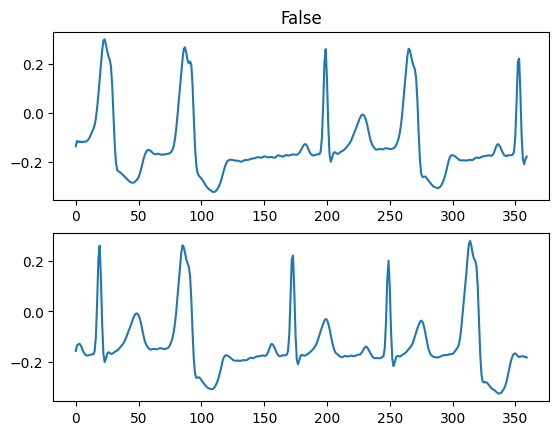

In [4]:
rand = np.random.randint(0,len(ecgSeg)-1)
plt.subplot(2,1,1)
plt.plot(ecgSeg[rand])
plt.title(ecgLabel[rand])
plt.subplot(2,1,2)
plt.plot(ecgFore[rand])
plt.show()

Extract positive signal from dataset.

In [5]:
segTrue = ecgSeg[ecgLabel]
labelTrue = np.ones((len(segTrue),1),dtype=bool)
print(segTrue.shape)
print(labelTrue.shape)

(30720, 360, 1)
(30720, 1)


Define LSTM-AE network
- to use cuDNN accelation, activation function must be 'tanh'

In [6]:
act = 'tanh'
#act = 'leaky_relu'
netInput = tf.keras.layers.Input(shape=(segLen,1))

encoder_1 = tf.keras.layers.LSTM(512,activation=act, return_sequences=True)(netInput)
encoder_2 = tf.keras.layers.LSTM(256,activation=act, return_sequences=False)(encoder_1)
rpt = tf.keras.layers.RepeatVector(segLen)(encoder_2)

decoder1_1 = tf.keras.layers.LSTM(128,activation=act, return_sequences=True)(rpt)
decoder1_2 = tf.keras.layers.LSTM(256,activation=act, return_sequences=True)(decoder1_1)
reconstruct = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='leaky_relu'),name="recons")(decoder1_2)

decoder2_1 = tf.keras.layers.LSTM(128,activation=act, return_sequences=True)(rpt)
decoder2_2 = tf.keras.layers.LSTM(256,activation=act, return_sequences=True)(decoder2_1)
forecast = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='leaky_relu'),name="fore")(decoder2_2)

lstmAE = tf.keras.Model(inputs=netInput,outputs=[reconstruct,forecast])
lstmAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='mse') # mean squared error
lstmAE.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 360, 512)     1052672     ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 256)          787456      ['lstm[0][0]']                   
                                                                                                  
 repeat_vector (RepeatVector)   (None, 360, 256)     0           ['lstm_1[0][0]']                 
                                                                                              

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=35, restore_best_weights=True)

history = lstmAE.fit(ecgSeg[:-4000], [ecgSeg[:-4000],ecgFore[:-4000]], epochs=500, batch_size=512,validation_split=0.05, callbacks=[callback])

Epoch 1/500
100/100 [==============================] - 127s 1s/step - loss: 0.0505 - recons_loss: 0.0256 - fore_loss: 0.0249 - val_loss: 0.0368 - val_recons_loss: 0.0186 - val_fore_loss: 0.0182
Epoch 2/500
100/100 [==============================] - 153s 2s/step - loss: 0.0446 - recons_loss: 0.0225 - fore_loss: 0.0221 - val_loss: 0.0447 - val_recons_loss: 0.0226 - val_fore_loss: 0.0221
Epoch 3/500
100/100 [==============================] - 170s 2s/step - loss: 0.0452 - recons_loss: 0.0229 - fore_loss: 0.0223 - val_loss: 0.0356 - val_recons_loss: 0.0178 - val_fore_loss: 0.0177
Epoch 4/500
100/100 [==============================] - 173s 2s/step - loss: 0.0444 - recons_loss: 0.0224 - fore_loss: 0.0220 - val_loss: 0.0369 - val_recons_loss: 0.0186 - val_fore_loss: 0.0183
Epoch 5/500
100/100 [==============================] - 173s 2s/step - loss: 0.0429 - recons_loss: 0.0216 - fore_loss: 0.0214 - val_loss: 0.0352 - val_recons_loss: 0.0177 - val_fore_loss: 0.0175
Epoch 6/500
100/100 [=========

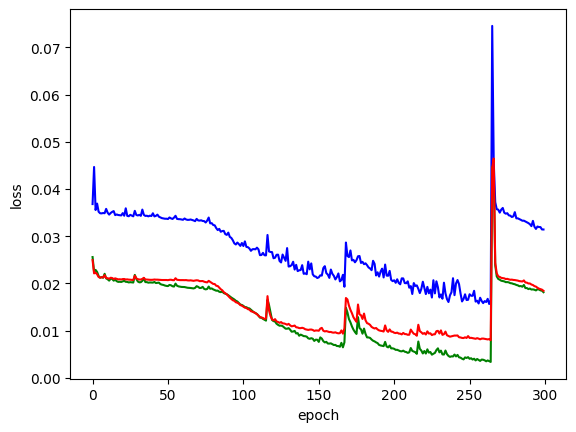

In [22]:
plt.plot(history.history['val_loss'],'b')
plt.plot(history.history['recons_loss'],'g')
plt.plot(history.history['fore_loss'],'r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [9]:
signTrue = ecgSeg[ecgLabel]
signFalse = ecgSeg[~ecgLabel]
foreTrue = ecgFore[ecgLabel]
foreFalse = ecgLabel[~ecgLabel]

In [10]:
x = ecgSeg[-4000:]
f = ecgFore[-4000:]
l = ecgLabel[-4000:]

xP = x[l]
xN = x[~l]
fP = f[l]
fN = f[~l]

lstmAE.evaluate(xP,[xP,fP])
lstmAE.evaluate(xN,[xN,fN])
# lstmAE.evaluate(xP,fP)
# lstmAE.evaluate(xN,fN)

85/85 [==============================] - 14s 167ms/step - loss: 0.0243 - recons_loss: 0.0088 - fore_loss: 0.0155


[0.02427593618631363, 0.008793255314230919, 0.015482681803405285]

In [11]:
recons, fore = np.array(lstmAE.predict(signTrue[1000].reshape(1,-1,1)))

1/1 [==============================] - 2s 2s/step


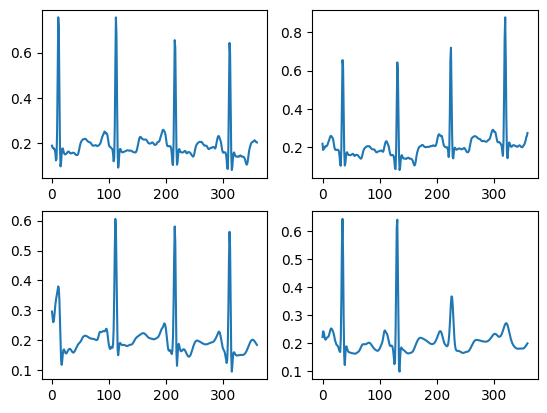

In [12]:
plt.subplot(2,2,1)
plt.plot(signTrue[1000])
plt.subplot(2,2,2)
plt.plot(foreTrue[1000])
plt.subplot(2,2,3)
plt.plot(recons[0,:,0])
plt.subplot(2,2,4)
plt.plot(fore[0,:,0])
plt.show()

Trained network transfer and define classification network

In [13]:
# Freeze weight of encoder
lstmAE.trainable=False
dense_1 = tf.keras.layers.Dense(256,activation='relu')(encoder_2)
dense_2 = tf.keras.layers.Dense(256,activation='relu')(dense_1)
classification = tf.keras.layers.Dense(1,activation='sigmoid')(dense_2)

Classifier = tf.keras.Model(inputs=netInput,outputs=classification)

Classifier.compile(loss = 'binary_crossentropy', 
                         optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                         metrics = ['accuracy'])

In [14]:
Classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 360, 512)          1052672   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,971,969
Trainable params: 131,841
Non-train

In [15]:
callback2 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history2 = Classifier.fit(x=ecgSeg[:-4000],
                                y=ecgLabel[:-4000],
                                epochs=50,
                                batch_size=512,
                                validation_split=0.05,
                                callbacks=callback2
                                )

Epoch 1/50
100/100 [==============================] - 34s 307ms/step - loss: 0.6487 - accuracy: 0.6376 - val_loss: 0.7053 - val_accuracy: 0.5334
Epoch 2/50
100/100 [==============================] - 34s 339ms/step - loss: 0.5481 - accuracy: 0.7622 - val_loss: 0.6133 - val_accuracy: 0.6470
Epoch 3/50
100/100 [==============================] - 34s 341ms/step - loss: 0.4513 - accuracy: 0.8100 - val_loss: 0.6553 - val_accuracy: 0.6701
Epoch 4/50
100/100 [==============================] - 34s 343ms/step - loss: 0.3947 - accuracy: 0.8358 - val_loss: 0.6520 - val_accuracy: 0.6802
Epoch 5/50
100/100 [==============================] - 34s 343ms/step - loss: 0.3571 - accuracy: 0.8541 - val_loss: 0.6557 - val_accuracy: 0.6873
Epoch 6/50
100/100 [==============================] - 34s 343ms/step - loss: 0.3298 - accuracy: 0.8676 - val_loss: 0.6392 - val_accuracy: 0.6895
Epoch 7/50
100/100 [==============================] - 34s 343ms/step - loss: 0.3093 - accuracy: 0.8804 - val_loss: 0.6611 - val_ac

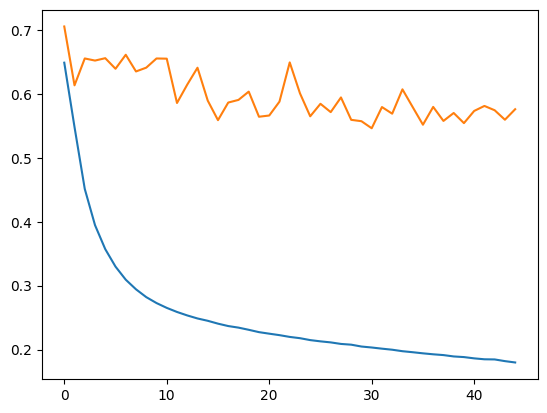

In [16]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

In [17]:
result = Classifier.evaluate(x=ecgSeg[-4000:],y=ecgLabel[-4000:])

125/125 [==============================] - 8s 65ms/step - loss: 0.2888 - accuracy: 0.8878


In [18]:
#from sklearn.metrics import ConfusionMatrixDisplay

pred = Classifier.predict(x=ecgSeg[-4000:])

#disp = ConfusionMatrixDisplay.

125/125 [==============================] - 8s 58ms/step


In [19]:
def cls(x):
    return x>0.5
pred = np.array(list(map(cls,pred)))
print(np.unique(pred,return_counts=True))

(array([False,  True]), array([2429, 1571], dtype=int64))


In [20]:
confusion = np.array([[0,0],[0,0]])
cnt= 0
for i, j in zip(pred.reshape(-1,), ecgLabel[-4000:]):
    confusion[0 if j else 1, 0 if i else 1] = confusion[0 if j else 1, 0 if i else 1]+1

In [21]:
print(confusion)
print((confusion[0,0]+confusion[1,1])/4000)

[[1208   86]
 [ 363 2343]]
0.88775
